In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings, time

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV

In [2]:
warnings.filterwarnings("ignore")  # Ignore all warnings
pd.set_option('display.max_columns', None)  # Display all columns

# Loading Data

### Load data after cleaning

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/MyDrive/computation data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = dir_path + 'data_cleaned.csv'
# data_path = r'data/data_cleaned.csv'

df = pd.read_csv(data_path)

In [5]:
data_path = dir_path + 'x_cleaned.csv'
# data_path = r'data/x_cleaned.csv'

dataframe = pd.read_csv(data_path)
preprocessed_data = dataframe.to_numpy()

### Apply PCA and LDA to cleaned data

In [6]:
print("Applying PCA to preprocessed data ... ", end="")
pca = PCA()
pca.fit(preprocessed_data)
pca_features = pca.transform(preprocessed_data)

num_pca_features = pca_features.shape[1]
print("Number of PCA Features:", num_pca_features)
print("Done")

Applying PCA to preprocessed data ... Number of PCA Features: 72
Done


In [7]:
print("Applying LDA to preprocessed data based on Label column... ", end="")
lda_label = LinearDiscriminantAnalysis()
lda_label.fit(preprocessed_data, df['Label'])
lda_features_label = lda_label.transform(preprocessed_data)
print("Done")
print(lda_features_label)

Applying LDA to preprocessed data based on Label column... Done
[[ 0.78772014]
 [ 0.07780769]
 [-1.09328415]
 ...
 [-0.51197248]
 [-4.65029719]
 [ 0.49596845]]


In [8]:
print("Applying LDA to preprocessed data based on Category column... ", end="")
lda_category = LinearDiscriminantAnalysis()
lda_category.fit(preprocessed_data, df['Cat'])
lda_features_category = lda_category.transform(preprocessed_data)
print("Done")
print(lda_features_category)

Applying LDA to preprocessed data based on Category column... Done
[[-2.87537687 -2.12245298  0.29908583  1.75825583]
 [25.09439745  0.61527825 -0.10577725 -1.16896629]
 [-2.07683571  2.86314317 -0.17095477 -1.48994132]
 ...
 [-2.24326841  2.75643787  0.67554598 -1.21584952]
 [-1.2487033   6.89710251 -2.44120123  0.63942495]
 [-3.08637055 -2.25402655 -0.34622806  1.12456015]]


In [9]:
print("Applying LDA to preprocessed data based on Subcategory column... ", end="")
lda_subcategory = LinearDiscriminantAnalysis()
lda_subcategory.fit(preprocessed_data, df['Sub_Cat'])
lda_features_subcategory = lda_subcategory.transform(preprocessed_data)
print("Done")
print(lda_features_subcategory)

Applying LDA to preprocessed data based on Subcategory column... Done
[[  3.95709237   0.32248335   1.42540973 ...  -0.49592922  -0.66594801
   -0.81960742]
 [-26.39633819   9.30322539  -1.58525828 ...   1.13150813  -0.43812038
   -1.79161469]
 [ -0.17853518  -3.66776297  -1.71620379 ...   1.15958833  -0.4544357
    0.18508939]
 ...
 [ -0.14319295  -3.82131393  -1.4578023  ...   0.9247459   -0.90769795
    0.33163727]
 [ -9.75651551 -12.14704021  -0.59452872 ...  -0.34884731   0.15438775
    0.37962823]
 [  3.43027743  -0.37439557   1.94673448 ...   0.95766415   0.1865384
    0.249115  ]]


We will define a function that performs PCA with a given number of components followed by LDA to avoid redundancy in our code

In [10]:
def perform_pca_lda(y, X=pca_features, n_components=72):
  pca_data = X[:, :n_components]

  lda = LinearDiscriminantAnalysis()
  lda.fit(pca_data, y)
  pca_lda_data = lda.transform(pca_data)

  return pca_lda_data

In [11]:
def print_pca_lda_results(pca_lda_data):
  # Print the shape of the transformed data
  print("Shape of transformed data:", pca_lda_data.shape)

  # Print the first few rows of the transformed data
  print("Transformed data:")
  print(pca_lda_data)

# Model Development

## Functions

We will first define functions to train and fine tune the SVM model to avoid redundancy in our code

### Train Model

In [12]:
def train_LinearSVC_Model(X, y, penalty='l2', loss='hinge', C=1.0, max_iter=100):

    """
    Implements training and testing of LinearSVC model with an 80/20 train-test split.

    Parameters:
        X: DataFrame of X features.
        y: Series of y variable.
        parameters that can be passed to LinearSVC function are added as optional parameters.
        check LinearSVC official documentation for more details.

    Returns:
        classifier: trained LinearSVC classifier.
        metrics: dictionary of evaluation metrics.
        conf_mat: ndarray of confusion matrix.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LinearSVC(penalty=penalty, loss=loss, max_iter=max_iter, C=C)

    # Train the classifier
    start_time = time.time()
    classifier.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Predict on the test set
    start_time = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Calibrate the classifier for probability estimation
    calibrated_classifier = CalibratedClassifierCV(classifier, method='sigmoid', cv='prefit')
    calibrated_classifier.fit(X_train, y_train)
    y_scores = calibrated_classifier.predict_proba(X_test)

    # Compute precision-recall pairs for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(set(y))):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_scores[:, i])
        average_precision[i] = average_precision_score(y_test == i, y_scores[:, i])
    precision_recall = [precision, recall, average_precision]


    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    metrics = {
        'n_classes':len(set(y)),
        'accuracy': round(accuracy_score(y_test, y_pred) * 100, 2),
        'balanced_accuracy': round(balanced_accuracy_score(y_test, y_pred) * 100, 2),
        'fit_time': round(fit_time  * 1000),
        'predict_time': round(predict_time  * 1000),
        'misclassified': np.sum(conf_mat) - np.sum(np.diag(conf_mat)),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1_score': round(f1_score(y_test, y_pred, average='weighted'), 3),
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
    }


    return classifier, metrics, conf_mat, precision_recall

### Print Metrics

In [13]:
def print_metrics(metrics, conf_mat, precision_recall):
    """
    Prints evaluation metrics and confusion matrix of model trained with train_LinearSVC_Model() function.

    Parameters:
        metrics: dictionary of evaluation metrics returned by train_LinearSVC_Model() function.
        conf_mat: ndarray of confusion matrix returned by train_LinearSVC_Model() function.
        precision_recall: list of precision-recall curve data.
    """

    # Print evaluation metrics
    print(f"Accuracy: {metrics['accuracy']}%")
    print(f"Balanced accuracy: {metrics['balanced_accuracy']}%")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"Weighted F1 score: {metrics['f1_score']}")
    print(f"Fit time: {metrics['fit_time']} ms")
    print(f"Predict time: {metrics['predict_time']} ms")

    print()
    print(f"Number of misclassified: {metrics['misclassified']}")

    # Plot confusion matrix, roc-auc curve, and pr curve
    sns.set(style="darkgrid")

    fig = plt.figure(figsize=(11,5), layout='constrained')
    gs = fig.add_gridspec(2,2)

    ax0 = fig.add_subplot(gs[0:2,0])
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax0)
    ax0.set_title('Confusion Matrix')
    ax0.set_xlabel('Predicted')
    ax0.set_ylabel('True')

    ax1 = fig.add_subplot(gs[0,1])
    ax1.plot(metrics['fpr'], metrics['tpr'], label = 'ROC curve (area = %0.2f)' % metrics['roc_auc'], color = 'darkorange', lw = 2)
    ax1.plot([0, 1], [0, 1],  lw=1.5, linestyle='--', color = 'darkslateblue')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.0])
    ax1.legend()
    ax1.set_xlabel('False Positive Rate (FPR)')
    ax1.set_ylabel('True Positive Rate (TPR)')
    ax1.set_title('ROC Curve')

    precision = precision_recall[0]
    recall = precision_recall[1]
    average_precision = precision_recall[2]

    colors = sns.color_palette('Set2')
    #colors = ['#f6f4d2', '#cbdfbd', '#f19c79', '#a44a3f']


    ax2 = fig.add_subplot(gs[1,1])

    for i, color in zip(range(metrics['n_classes']), colors):
        ax2.plot(recall[i], precision[i], color=color, lw=2.5, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.1])
    ax2.legend()
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision_recall Curve')

    plt.show()

### Fine-tune the Model

In [14]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC


def fine_tune_LinearSVC(X, y, test_size=0.2, random_state=None, cv=5, scoring='accuracy', n_iter=200):
    """
    Performs hyperparameter tuning for LinearSVC model using RandomizedSearchCV with data splitting.
    Parameters:
        X: DataFrame of X features.
        y: Series of y variable.
        test_size: Proportion of data for the test set (default: 0.2).
        random_state: Seed for random splitting (default: None).
        cv: Number of folds for cross-validation (default: 5).
        scoring: Evaluation metric to use for scoring (default: 'accuracy').
        n_iter: Number of iterations for randomized search (default: 100).

    Returns:
        best_params: Dictionary containing the best hyperparameters found (C, loss, tol).
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define hyperparameter distributions
    param_dist = {
      'C': [0.001, 0.01, 0.1, 1, 10, 100],
      'loss': ["hinge", "squared_hinge"],
      #'tol': [1e-3, 1e-4, 1e-5]
    }

    clf = LinearSVC()
    search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=cv, scoring=scoring, n_iter=n_iter, random_state=random_state)

    search.fit(X_train, y_train)

    # Access best parameters
    best_params = search.best_params_

    return best_params


## Binary Classification

### Without dimentionality reduction

In [15]:
print("Training model without dimentionality reduction..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(preprocessed_data, df['Label'])

Training model without dimentionality reduction..


Accuracy: 100.0%
Balanced accuracy: 100.0%
Precision: 1.0
Recall: 1.0
Weighted F1 score: 1.0
Fit time: 7457 ms
Predict time: 14 ms

Number of misclassified: 1


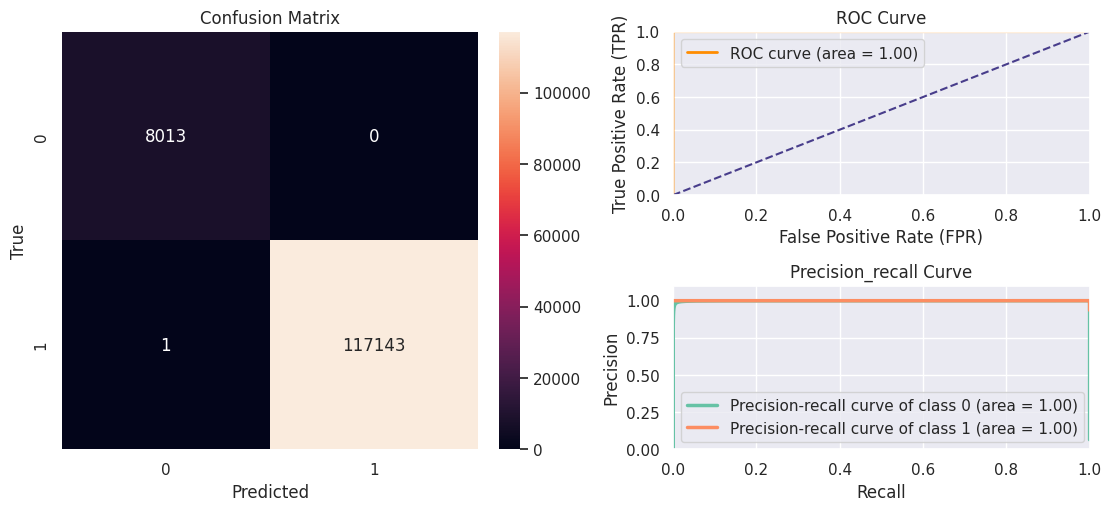

In [16]:
print_metrics(metrics, conf_mat, precision_recall)

##### **Fine tuning**

In [17]:
# fine_tune_LinearSVC(preprocessed_data, df['Label'])

In [18]:
print("Training model without dimentionality reduction..")
Tuned_classifier, Tuned_metrics, Tuned_conf_mat, Tuned_conf_precision_recall = train_LinearSVC_Model(preprocessed_data, df['Label'], C=10.0, loss="squared_hinge")

Training model without dimentionality reduction..


Accuracy: 100.0%
Balanced accuracy: 100.0%
Precision: 1.0
Recall: 1.0
Weighted F1 score: 1.0
Fit time: 7582 ms
Predict time: 14 ms

Number of misclassified: 1


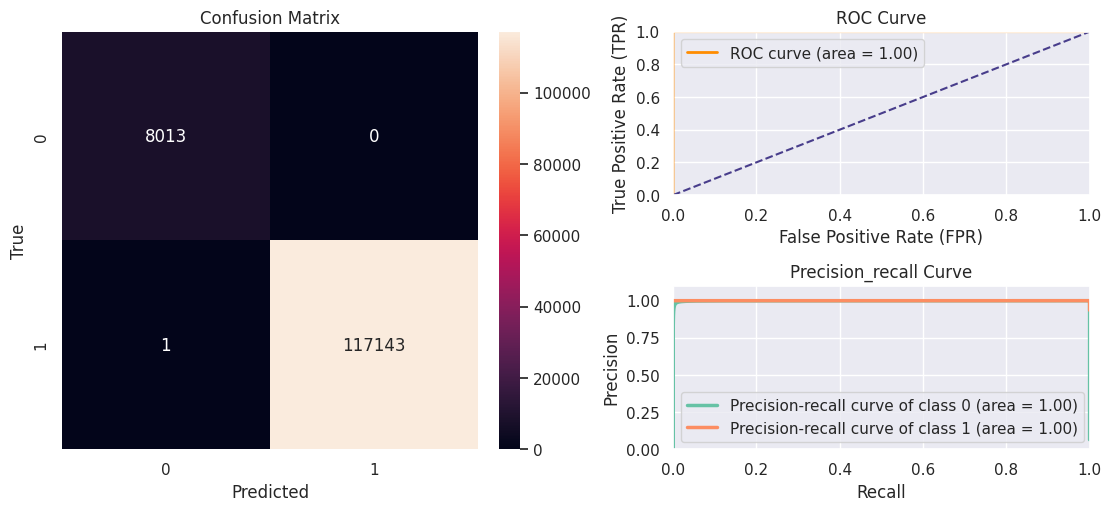

In [19]:
print_metrics(Tuned_metrics, Tuned_conf_mat, Tuned_conf_precision_recall)

We can see that the model gives good accuracy. However, the fit and predit time are too large for an iot IDS model, so we need to use dimentionality reduction and fine tune the models to get lower fit and predict times.

### LDA Only

#### Using Label Column for LDA

In [20]:
print("Training model with Label LDA feature..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(lda_features_label, df['Label'])
metrics_lda_label=metrics

Training model with Label LDA feature..


Accuracy: 98.85%
Balanced accuracy: 92.83%
Precision: 0.99
Recall: 0.997
Weighted F1 score: 0.988
Fit time: 842 ms
Predict time: 2 ms

Number of misclassified: 1434


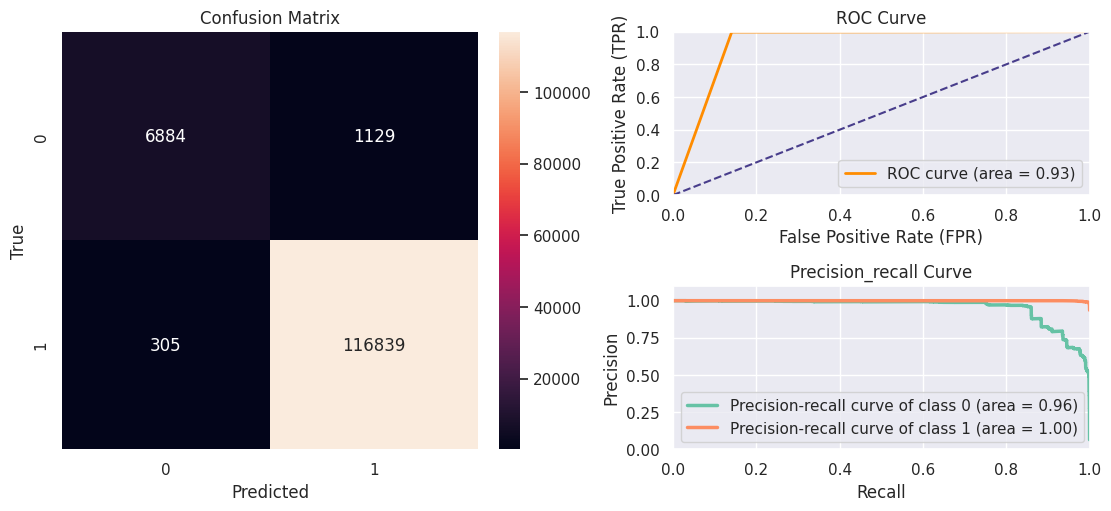

In [21]:
print_metrics(metrics, conf_mat,precision_recall)

#### Using Category Column for LDA

In [52]:
print("Training model with Category LDA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(lda_features_category, df['Label'])
lda_categories=metrics

Training model with Category LDA features..


Accuracy: 99.67%
Balanced accuracy: 98.22%
Precision: 0.998
Recall: 0.999
Weighted F1 score: 0.997
Fit time: 2829 ms
Predict time: 7 ms

Number of misclassified: 409


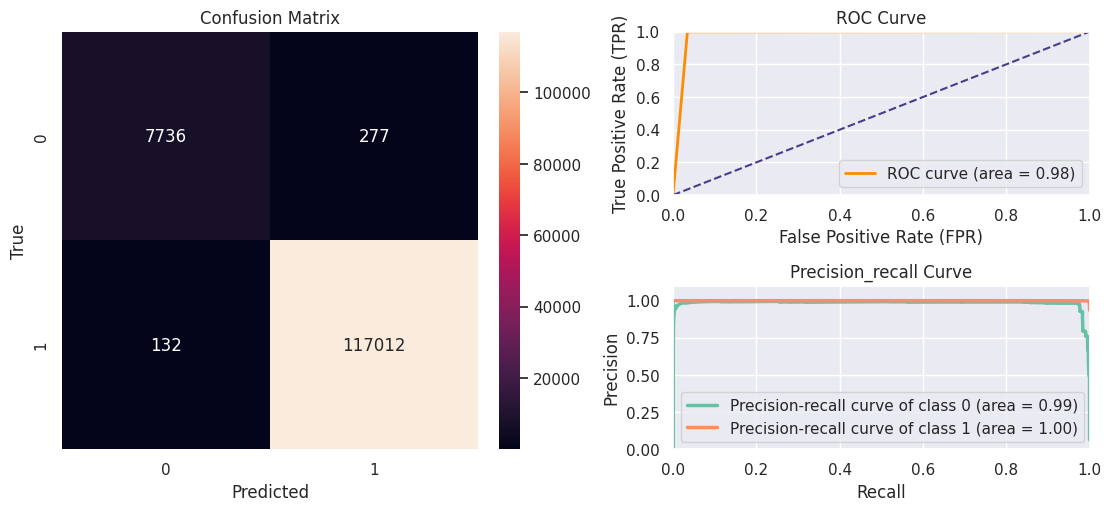

In [53]:
print_metrics(metrics, conf_mat, precision_recall)

##### **Fine tuning**

In [24]:
# fine_tune_LinearSVC(lda_features_category, df['Label'])

In [56]:
print("Training Tuned model with Category LDA features..")
Tuned_cat_classifier, Tuned_cat_metrics, Tuned_cat_conf_mat, Tuned_cat_precision_recall = train_LinearSVC_Model(lda_features_category, df['Label'], loss="hinge", C=1.0)
metrics_lda_categories=Tuned_cat_metrics

Training Tuned model with Category LDA features..


Accuracy: 99.68%
Balanced accuracy: 98.3%
Precision: 0.998
Recall: 0.999
Weighted F1 score: 0.997
Fit time: 1663 ms
Predict time: 4 ms

Number of misclassified: 397


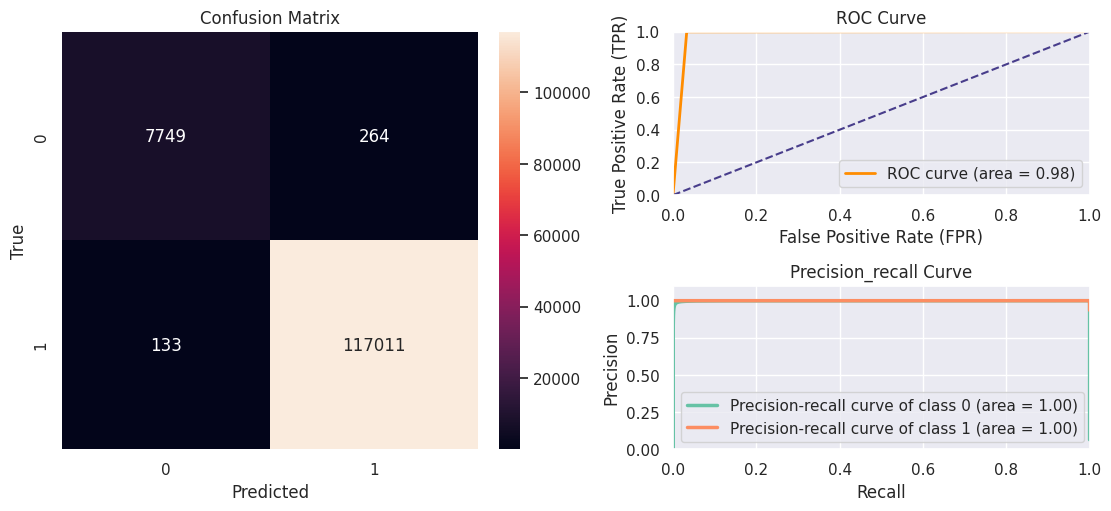

In [57]:
print_metrics(Tuned_cat_metrics, Tuned_cat_conf_mat, Tuned_conf_precision_recall)


#### Using Subcategory Column for LDA

In [58]:
print("Training model with Subcategory LDA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(lda_features_subcategory, df['Label'])
lda_subcategories=metrics

Training model with Subcategory LDA features..


Accuracy: 99.98%
Balanced accuracy: 99.94%
Precision: 1.0
Recall: 1.0
Weighted F1 score: 1.0
Fit time: 1537 ms
Predict time: 8 ms

Number of misclassified: 20


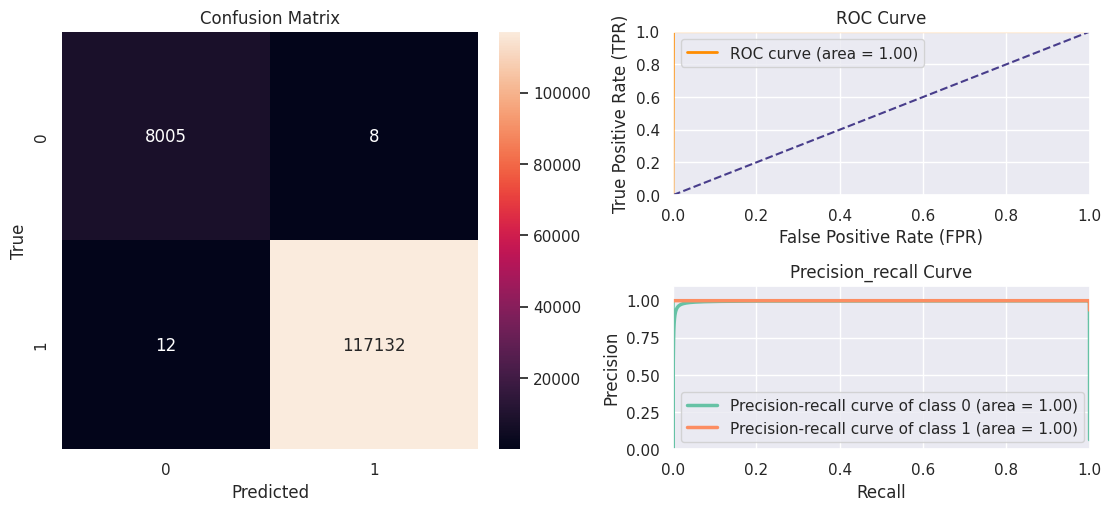

In [59]:
print_metrics(metrics, conf_mat,precision_recall)

##### Fine tuning

In [29]:
# fine_tune_LinearSVC(lda_features_subcategory, df['Label'])

In [62]:
print("Training Tuned model with Subcategory LDA features..")
Tuned_subcat_classifier, Tuned_subcat_metrics, Tuned_subcat_conf_mat, Tuned_subcat_precision_recall = train_LinearSVC_Model(lda_features_subcategory, df['Label'], C=100.0, loss="hinge")
metrics_lda_subcategories=Tuned_subcat_metrics

Training Tuned model with Subcategory LDA features..


Accuracy: 99.98%
Balanced accuracy: 99.96%
Precision: 1.0
Recall: 1.0
Weighted F1 score: 1.0
Fit time: 998 ms
Predict time: 3 ms

Number of misclassified: 21


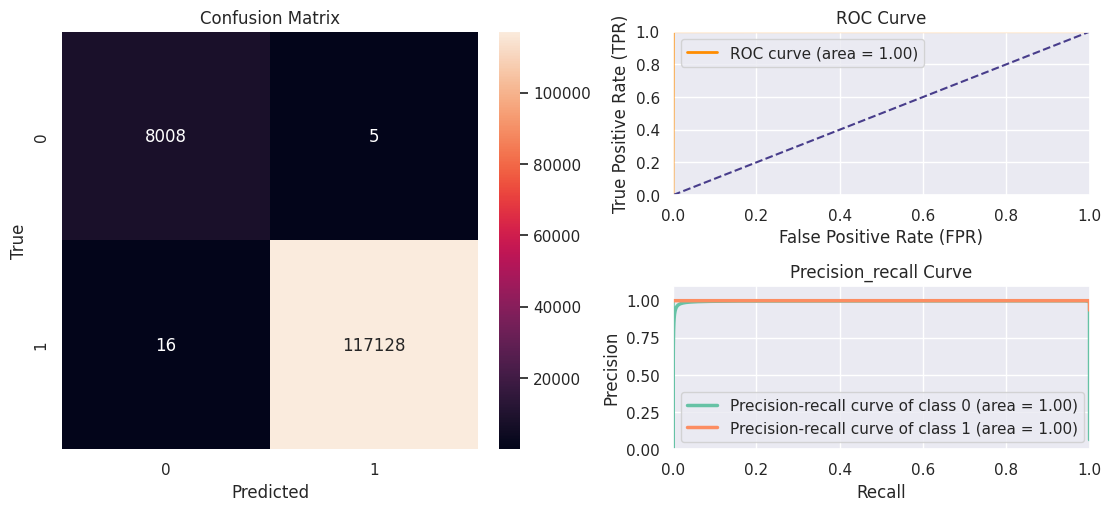

In [63]:
print_metrics(Tuned_subcat_metrics, Tuned_subcat_conf_mat, Tuned_subcat_precision_recall)

The models' accuracy are already high before fine tuning. However, fine tuning helped reduce fit time, as shown below.

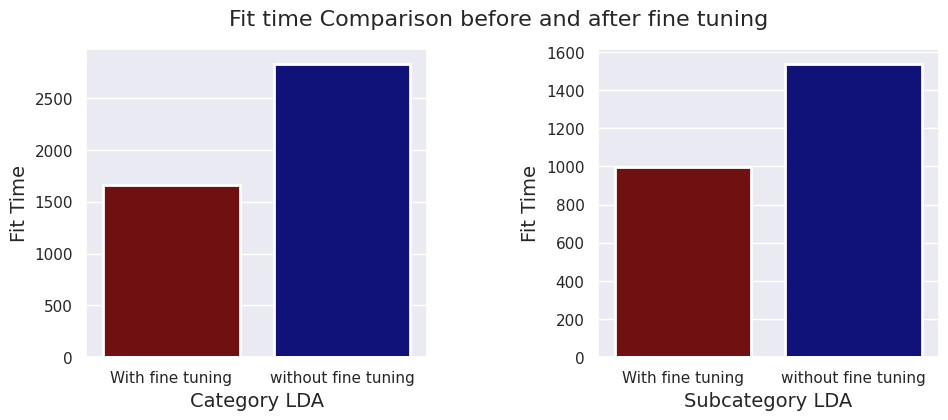

In [64]:
# heya el times m4 sabta m3 kol run bs lw 3amalna run kaza mara fi range arkam keda howa eli byetla3 fl 8aleb

accuracy_data1 = {
    'Model': ['With fine tuning', 'without fine tuning'],
    'Fit time': [metrics_lda_categories['fit_time'],lda_categories['fit_time']]
}

accuracy_data2 = {
    'Model': ['With fine tuning', 'without fine tuning'],
    'Fit time': [metrics_lda_subcategories['fit_time'],lda_subcategories['fit_time']]
}

df_accuracy = pd.DataFrame(accuracy_data1)

sns.set(style="darkgrid")
pal = {'With fine tuning': "maroon", 'without fine tuning': "darkblue"}

# Create the bar plot
plt.figure(figsize=(11, 4))
plt.subplot(1,2,1)
ax = sns.barplot(x="Model",
                 y="Fit time",
                 data=df_accuracy,
                 palette=pal,
                 linewidth=2,
                 capsize=.1)

plt.ylabel("Fit Time", fontsize=14)
plt.xlabel("Category LDA", fontsize=14)

df_accuracy = pd.DataFrame(accuracy_data2)

plt.subplot(1,2,2)
ax = sns.barplot(x="Model",
                 y="Fit time",
                 data=df_accuracy,
                 palette=pal,
                 linewidth=2,
                 capsize=.1)

plt.ylabel("Fit Time", fontsize=14)
plt.xlabel("Subcategory LDA", fontsize=14)

plt.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

plt.suptitle("Fit time Comparison before and after fine tuning", fontsize=16)
plt.show()


### Combining PCA and LDA

We can see that performing LDA on Sub_Cat column gives the best results, but we will combine PCA and LDA to see if we can optimize the fit and predict times, or the accuracy of models with other LDA columns

#### First 11 components (best from skree plot)

#### Using Subcategory LDA and 11 PCA components

In [88]:
pca_lda_data = perform_pca_lda(y=df['Sub_Cat'], n_components=11)
print_pca_lda_results(pca_lda_data)

Shape of transformed data: (625783, 8)
Transformed data:
[[-3.31627774e+00 -2.27638124e-01  1.04547214e+00 ...  3.82284916e-01
   5.16517089e-02  2.23804095e-01]
 [ 1.89471512e+01  8.17870808e+00 -3.85282212e-01 ...  1.06499609e-01
  -5.10539471e-01  3.40230521e-01]
 [ 1.76291354e+00 -2.44166966e+00 -1.77245697e+00 ...  1.45901956e+00
  -3.41832118e-01  5.60595791e-01]
 ...
 [ 1.43887907e+00 -2.12556305e+00 -1.58492596e+00 ...  2.27970187e-01
  -1.24678601e+00  3.68358287e-01]
 [ 1.22808230e+01 -8.13801200e+00 -3.47376636e-01 ...  5.18321542e-01
   7.96877557e-01  7.12016866e-02]
 [-3.20706562e+00 -3.87137872e-01  1.42156652e+00 ...  7.27083799e-01
   8.03523801e-03  6.29109748e-01]]


In [99]:
print("Training model with Subcategory PCA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(pca_lda_data, df['Label'])

Training model with Subcategory PCA features..


Accuracy: 99.94%
Balanced accuracy: 99.87%
Precision: 1.0
Recall: 0.999
Weighted F1 score: 0.999
Fit time: 1047 ms
Predict time: 4 ms

Number of misclassified: 79


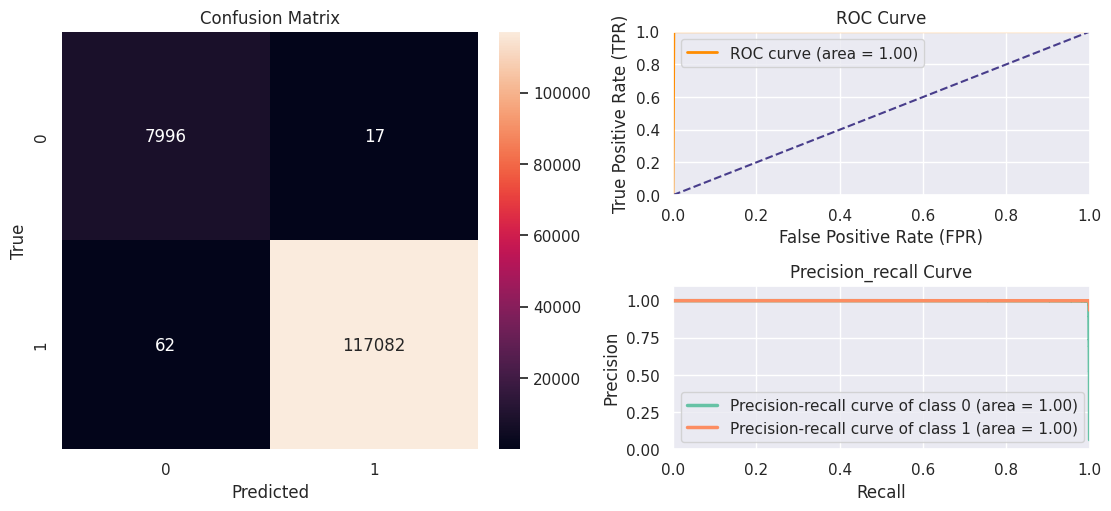

In [100]:
print_metrics(metrics, conf_mat, precision_recall)

##### Fine tuning

In [36]:
# fine_tune_LinearSVC(pca_lda_data, df['Label'])

In [105]:
print("Training Tuned model with Subcategory PCA features..")
Tuned_pca11_classifier, Tuned_pca11_metrics, Tuned_pca11_conf_mat, Tuned_pca11_precision_recall = train_LinearSVC_Model(pca_lda_data, df['Label'], loss="squared_hinge", C=1.0)
metrics_pca11_subcategories=Tuned_pca11_metrics

Training Tuned model with Subcategory PCA features..


Accuracy: 99.84%
Balanced accuracy: 98.94%
Precision: 0.999
Recall: 1.0
Weighted F1 score: 0.998
Fit time: 981 ms
Predict time: 7 ms

Number of misclassified: 199


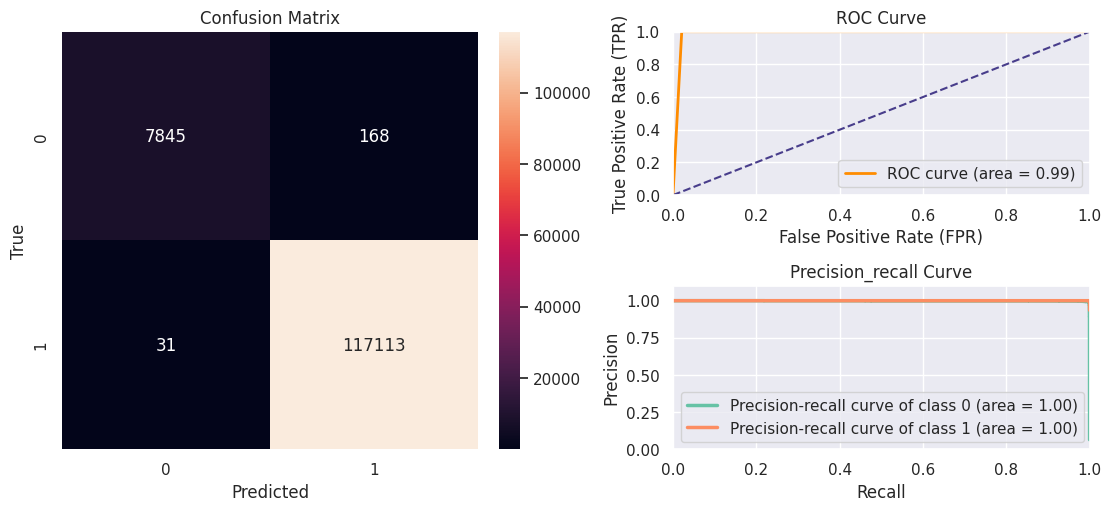

In [106]:
print_metrics(Tuned_pca11_metrics, Tuned_pca11_conf_mat,Tuned_pca11_precision_recall)

#### Using Category LDA and 11 PCA components

In [107]:
pca_lda_data = perform_pca_lda(y=df['Cat'], n_components=11)
print_pca_lda_results(pca_lda_data)

Shape of transformed data: (625783, 4)
Transformed data:
[[  2.244625     1.41341166  -0.85230665   1.18634375]
 [-15.83667788   0.96214886   0.06575718   0.17804244]
 [  0.55278662  -2.73089669   1.87146541  -0.88617961]
 ...
 [  0.46289409  -2.50131052   0.48345852  -1.15155737]
 [  0.20774996  -6.26616587  -1.08879648   0.73286773]
 [  2.46149641   1.66264118  -0.63563501   1.73283945]]


In [112]:
print("Training model with category PCA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(pca_lda_data, df['Label'])

Training model with category PCA features..


Accuracy: 99.84%
Balanced accuracy: 99.66%
Precision: 1.0
Recall: 0.999
Weighted F1 score: 0.998
Fit time: 1187 ms
Predict time: 7 ms

Number of misclassified: 206


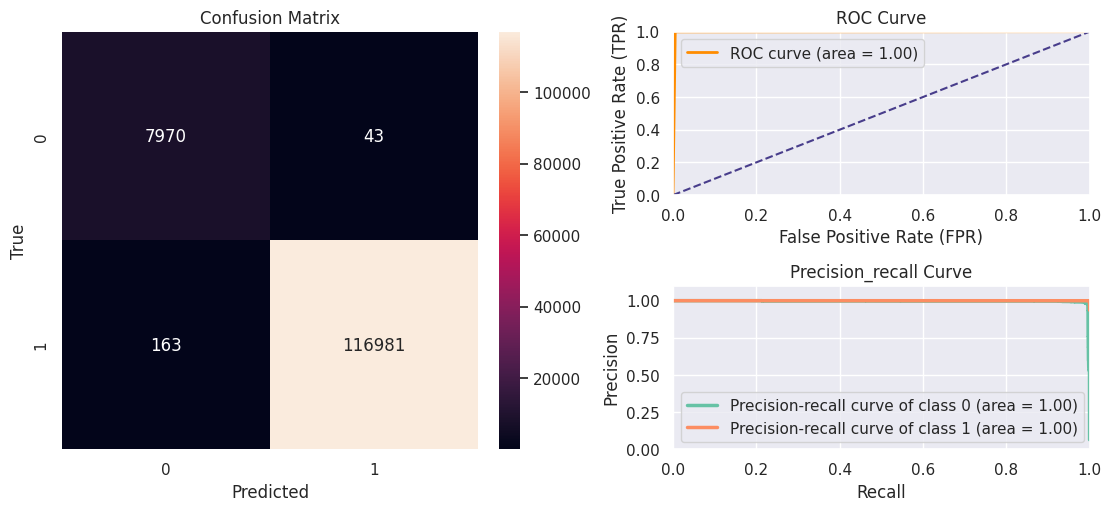

In [113]:
print_metrics(metrics, conf_mat, precision_recall)

##### Fine tuning

In [42]:
# fine_tune_LinearSVC(pca_lda_data, df['Label'])

In [120]:
print("Training Tuned model with category PCA features..")
Tuned_pca11_classifier, Tuned_pca11_metrics, Tuned_pca11_conf_mat, Tuned_pca11_precision_recall = train_LinearSVC_Model(pca_lda_data, df['Label'], loss="squared_hinge", C=1.0)
metrics_pca11_categories=Tuned_pca11_metrics

Training Tuned model with category PCA features..


Accuracy: 99.85%
Balanced accuracy: 99.66%
Precision: 1.0
Recall: 0.999
Weighted F1 score: 0.998
Fit time: 800 ms
Predict time: 3 ms

Number of misclassified: 191


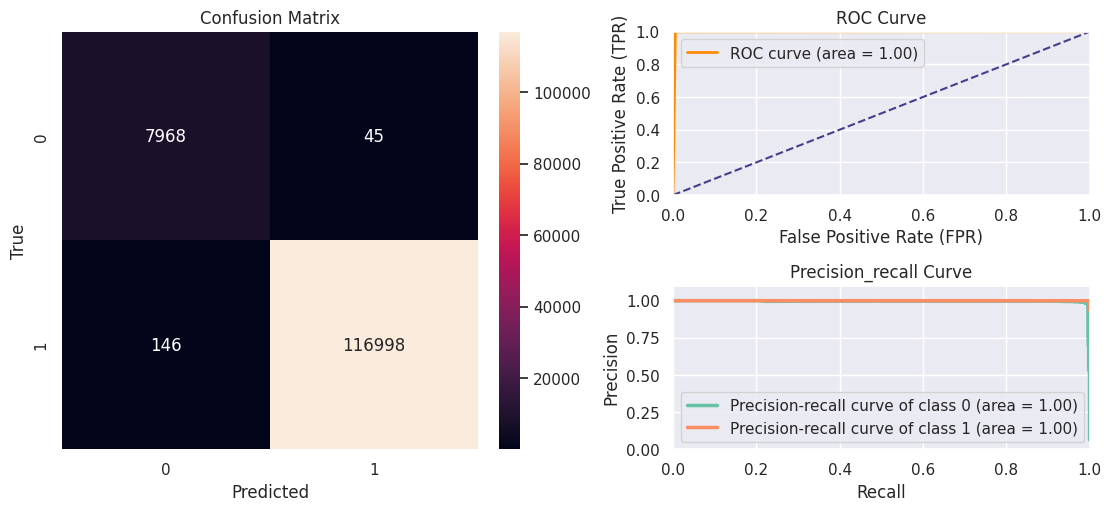

In [121]:
print_metrics(Tuned_pca11_metrics, Tuned_pca11_conf_mat, Tuned_pca11_precision_recall)

## Using Subcategory LDA and 30 PCA components

In [122]:
pca_lda_data = perform_pca_lda(y=df['Sub_Cat'], n_components=30)
print_pca_lda_results(pca_lda_data)

Shape of transformed data: (625783, 8)
Transformed data:
[[ 3.70855732e+00  2.54459973e-01  1.63642805e+00 ... -6.02868353e-01
  -1.03804413e+00 -5.05800015e-01]
 [-2.49215143e+01  9.82707632e+00 -6.56069412e-01 ... -1.89946570e-01
  -1.81383787e+00  2.23126977e-01]
 [-5.05833049e-01 -3.57030686e+00 -1.81552166e+00 ...  1.79611927e+00
  -6.19179222e-02  2.08254660e-01]
 ...
 [-3.30630838e-01 -3.55953712e+00 -1.40230874e+00 ...  8.20042626e-01
  -8.82145705e-01  3.54511835e-01]
 [-1.01485730e+01 -1.16520398e+01 -7.87240463e-01 ... -2.21342561e-01
   3.70781828e-01  4.13781424e-02]
 [ 3.35793963e+00 -3.64502267e-01  2.06724259e+00 ...  6.71676570e-01
  -1.64683289e-02  2.86518028e-01]]


In [123]:
print("Training model with 30 Subcategory PCA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(pca_lda_data, df['Label'])
metrics_pca30_subcategories=metrics

Training model with 30 Subcategory PCA features..


Accuracy: 99.99%
Balanced accuracy: 99.96%
Precision: 1.0
Recall: 1.0
Weighted F1 score: 1.0
Fit time: 2021 ms
Predict time: 7 ms

Number of misclassified: 12


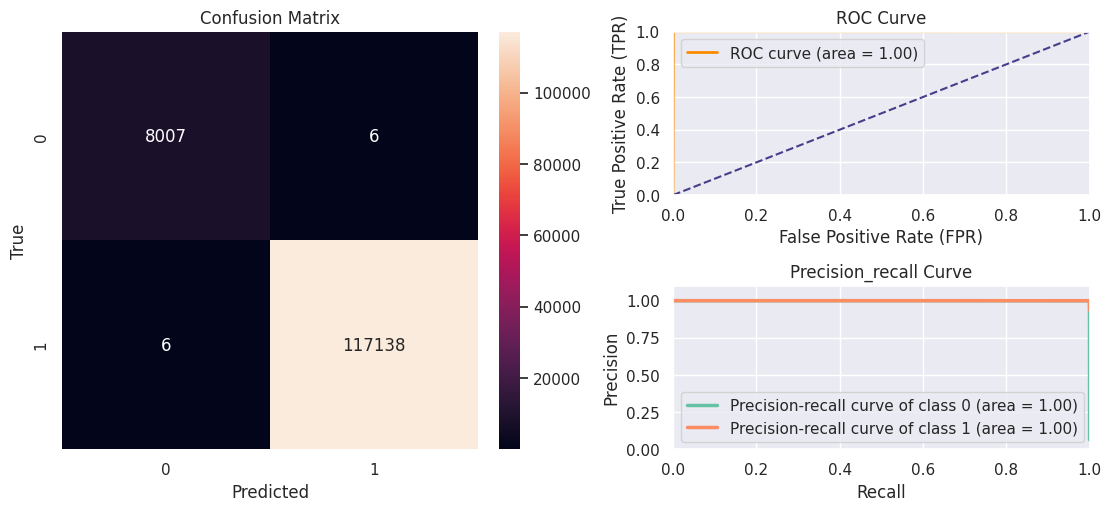

In [124]:
print_metrics(metrics, conf_mat, precision_recall)

In [125]:
metrics_data = {
    "Model": ["With Label LDA Feature", "With Category LDA Features", "With Subcategory LDA Features",
              "11 PCA components and LDA using Subcategory column", "11 PCA components and LDA using Category column",
              '30 PCA components and LDA using Subcategory column'],
}

# metrics to include
metrics_to_include = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_score', 'fit_time', 'predict_time']

# add metrics to metrics_data dictionary
for metric in metrics_to_include:
    metrics_data[metric.capitalize()] = [globals().get(f"metrics_{name}")[metric] for name in ['lda_label', 'lda_categories', 'lda_subcategories', 'pca11_subcategories', 'pca11_categories','pca30_subcategories']]

# Create dataframe
df_metrics = pd.DataFrame(metrics_data)


In [126]:
# draw comparaison table
df_metrics.sort_values(by="Balanced_accuracy", ascending=False, inplace=True)
comparison_table = df_metrics.style.background_gradient(cmap='YlGn').set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'neon',
    'font-size': '15px'
})
comparison_table

,Model,Accuracy,Balanced_accuracy,Precision,Recall,F1_score,Fit_time,Predict_time
2,With Subcategory LDA Features,99.980000,99.960000,1.000000,1.000000,1.000000,998,3
5,30 PCA components and LDA using Subcategory column,99.990000,99.960000,1.000000,1.000000,1.000000,2021,7
4,11 PCA components and LDA using Category column,99.850000,99.660000,1.000000,0.999000,0.998000,800,3
3,11 PCA components and LDA using Subcategory column,99.840000,98.940000,0.999000,1.000000,0.998000,981,7
1,With Category LDA Features,99.680000,98.300000,0.998000,0.999000,0.997000,1663,4
0,With Label LDA Feature,98.850000,92.830000,0.990000,0.997000,0.988000,842,2


In [127]:
# Drop two models with smallest balanced accuracy
df_metrics.sort_values(by="Balanced_accuracy", ascending=False, inplace=True)

# Get index of rows
dropped_rows_indices = df_metrics.tail(2).index.tolist()

dropped_rows = df_metrics.loc[dropped_rows_indices]

print("Dropped rows:")
print(dropped_rows.to_string())

# Remove rows
new_df = df_metrics.iloc[:-2]

comparison_table = new_df[['Model','Balanced_accuracy']].style.background_gradient(cmap='GnBu').set_properties(**{
  'font-family': 'Lucida Calligraphy',
  'color': 'neon',
  'font-size': '15px'
})

print("\nComparison Table:")
comparison_table


Dropped rows:
                        Model  Accuracy  Balanced_accuracy  Precision  Recall  F1_score  Fit_time  Predict_time
1  With Category LDA Features     99.68              98.30      0.998   0.999     0.997      1663             4
0      With Label LDA Feature     98.85              92.83      0.990   0.997     0.988       842             2

Comparison Table:


,Model,Balanced_accuracy
2,With Subcategory LDA Features,99.960000
5,30 PCA components and LDA using Subcategory column,99.960000
4,11 PCA components and LDA using Category column,99.660000
3,11 PCA components and LDA using Subcategory column,98.940000


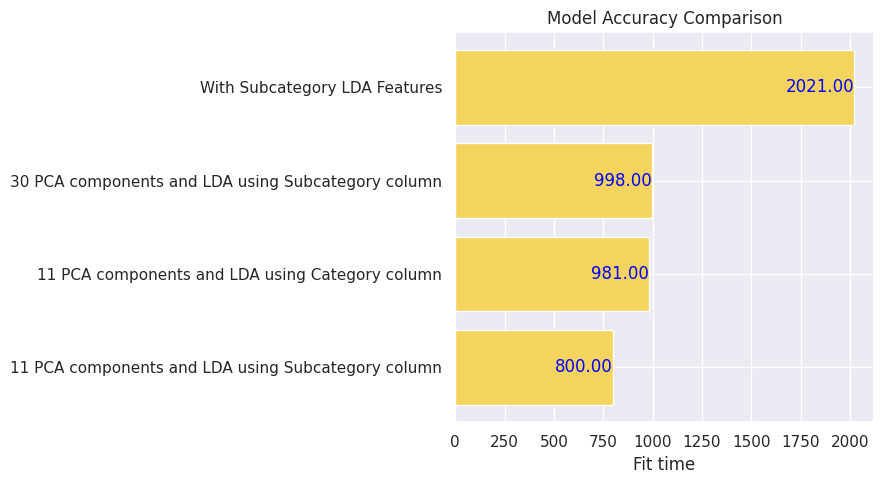

In [128]:
classifiers = new_df['Model']
Fit_time = new_df['Fit_time']

# sort accuracy in descending order but doesn't reassign to 'accuracy' variable
sorted_Fit_time = Fit_time.sort_values(ascending=False)

y = range(len(classifiers))

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.barh(y, sorted_Fit_time, color='#f4d35e')

ax.set_xlabel('Fit time')
ax.set_title('Model Accuracy Comparison')
ax.set_yticks(y)
ax.set_yticklabels(classifiers)
ax.invert_yaxis()  # labels read top-to-bottom

for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 0.05
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
            va='center', ha='right' if width > 0 else 'left', color='blue')

fig.tight_layout()

plt.show()

### **We can Conclude that Tuned model with Subategory LDA features and Binary Classification with 11 PCA components and LDA using Subcategory are the best**



